## Import Data ##

In [44]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [22]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)
print(df.shape)
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.drop(columns=["article_link"], inplace=True, axis=1)
df

(26709, 3)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


## Training Model ##

In [26]:
X = np.array(df["headline"])
y = np.array(df["is_sarcastic"])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [30]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [32]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(18695,)
(4007,)
(4006,)


In [46]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

In [48]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = [tokenizer(x,
                           max_length = 100,
                           truncation = True,
                           padding = "max_length",
                           return_tensors = "pt").to(device)
                           for x in X
                 ]
        self.y = torch.tensor(y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [50]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [71]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [54]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = BATCH_SIZE, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = BATCH_SIZE, shuffle = True)

In [58]:
class MyModel(nn.Module):
    def __init__(self, bert):
        super(MyModel, self).__init__()
        
        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        #Forward Propagation
        pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        
        return output

In [60]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [65]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [67]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

In [73]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for index, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)

        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction, labels)
        
        total_loss_train += batch_loss.item()
        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        #Back Propagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for index, data in enumerate(validation_dataloader):
            inputs, labels = data
            inputs.to(device)
            labels.to(device)

            prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
            batch_loss = criterion(prediction, labels)
        
            total_loss_val += batch_loss.item()
            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1 
    Training Loss: 0.214 
    Training Accuracy: 84.3327 
    Validation Loss: 0.0455 
    Validation Accuracy: 84.6019
Epoch no. 2 
    Training Loss: 0.1995 
    Training Accuracy: 85.1886 
    Validation Loss: 0.0441 
    Validation Accuracy: 84.3524
Epoch no. 3 
    Training Loss: 0.1913 
    Training Accuracy: 85.7983 
    Validation Loss: 0.0448 
    Validation Accuracy: 84.1527
Epoch no. 4 
    Training Loss: 0.1878 
    Training Accuracy: 86.007 
    Validation Loss: 0.0425 
    Validation Accuracy: 85.6002
Epoch no. 5 
    Training Loss: 0.1839 
    Training Accuracy: 86.2691 
    Validation Loss: 0.0426 
    Validation Accuracy: 85.2009
Epoch no. 6 
    Training Loss: 0.1823 
    Training Accuracy: 86.6328 
    Validation Loss: 0.0418 
    Validation Accuracy: 85.8747
Epoch no. 7 
    Training Loss: 0.18 
    Training Accuracy: 86.8147 
    Validation Loss: 0.0416 
    Validation Accuracy: 86.1742
Epoch no. 8 
    Training Loss: 0.1779 
    Training Accuracy: 87.

In [89]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for index, data in enumerate(testing_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)
        
        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_test += acc

        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f'''Accuracy Score: {round((total_acc_test/testing_data.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 86.6201 
Loss: 3.47


## Post-Training Analysis ##

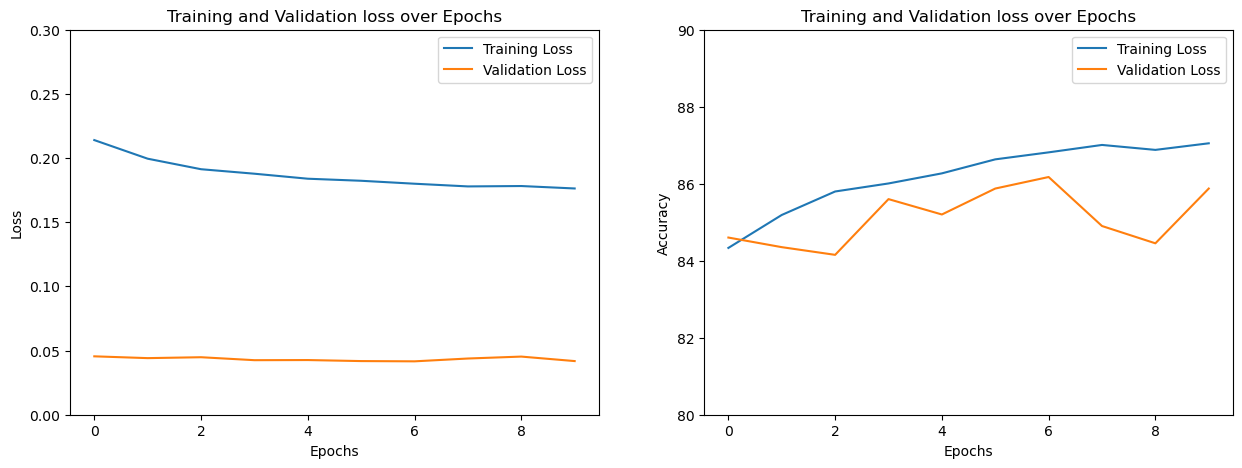

In [99]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.3])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([80,90])
axs[1].legend()

plt.show()

In [101]:
torch.save(model.state_dict(), "Sarcasm.pth")

In [105]:
loaded_model = MyModel(bert_model).to(device)
loaded_model.load_state_dict(torch.load("Sarcasm.pth"))
loaded_model.eval()

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin